<a href="https://colab.research.google.com/github/DanielGreiner/Masterarbeit/blob/main/Isothermal_steady_state_PFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [156]:
# @title import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch as to
from scipy.integrate import odeint

In [157]:
# @title check library versions
print("tensorflow:" + str(tf.__version__))
print("numpy:" + str(np.__version__))
print("pandas:" + str(pd.__version__))
#print("torch:" + str(to.__version__))

tensorflow:2.13.0
numpy:1.23.5
pandas:1.5.3


# Reaktionen

  \begin{array}{lll}
  \text{Methanol steam reforming (MSR):}&\kern 3pc CH_3OH_{(g)}+H_2O_{(g)}\kern 0.5pc{\overset{k_{1, eff}}{\rightleftharpoons}}\kern 0.5pc 3H_{2(g)}+CO_{2(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 49\enspace \frac{kJ}{mol} \\
  \text{Methanol decomposition (MD):}&\kern 3pc CH_3OH_{(g)}\kern 0.5pc {\overset{k_{2, eff}}{\rightleftharpoons}}\kern 0.5pc 2H_{2(g)}+CO_{(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 91\enspace \frac{kJ}{mol} \\
  \text{Water gas shift (WGS):}&\kern 3pc CO_{(g)}+H_2O_{(g)}\kern 0.5pc{\overset{k_{3, eff}}{\rightleftharpoons}}\kern 0.5pc H_{2(g)}+CO_{2(g)}&\kern 3pc\Delta_r H_{m}^{o}= - 41\enspace \frac{kJ}{mol}
  \end{array}


#Setup

**Indexing in arrays:**

\begin{array}{lllll}
H_2 & H_2O & CO & CO_2 & CH_3OH \\
0 & 1 & 2 & 3 & 4 \\
\end{array}

In [158]:
# @title Reaktorkonstanten laden
u = 1.500
A = 3*10**-3
v = u*A
Vges = 50
V0 = 0
steps = 1000
dV = (Vges-V0)/steps
Vspan = np.arange(V0, Vges + dV, dV)
z = Vges/A
r = np.sqrt(A/np.pi)

T0 = 273
n = 1

stepssplit = steps//2
Vspansplit = np.arange(V0, Vges/2+dV, dV)

# print(steps)
# print(len(Vspansplit))
# print(stepssplit)
# print(Vspansplit)
# print(Vspan)

In [159]:
# @title Startwerte

C0_H2 = 0
C0_H2O = 0.6
C0_CO = 0.05
C0_CO2 = 0
C0_MeOH = 0.6

IC = np.array([C0_H2, C0_H2O, C0_CO, C0_CO2, C0_MeOH])

In [160]:
# @title Kinetikdaten laden

R = 8.314 #J mol-1 K-1

#BiCat
#MSR
k0_MSR_S = 4.2*10**(-6) # kmol kg-1 h-1
EA_MSR_S = 4.978*1000 #J mol-1
b_MeOH_MSR_S = - 0.428
b_H2O_MSR_S = - 0.949

k0_MSR_M = 2.1*10**(-6) # kmol kg-1 h-1
k0_MSR_K = 2.7*10**(-6) # kmol kg-1 h-1
k0_MSR_L = 3.3*10**(-6) # kmol kg-1 h-1

EA_MSR_MKL = 5.566*1000 #J mol-1
b_MeOH_MSR_MKL = - 0.43
b_H2O_MSR_MKL = - 0.949

MSR = np.array(
    [[k0_MSR_S, EA_MSR_S, b_MeOH_MSR_S, b_H2O_MSR_S],
    [k0_MSR_M, EA_MSR_MKL, b_MeOH_MSR_MKL, b_H2O_MSR_MKL],
    [k0_MSR_K, EA_MSR_MKL, b_MeOH_MSR_MKL, b_H2O_MSR_MKL],
    [k0_MSR_L, EA_MSR_MKL, b_MeOH_MSR_MKL, b_H2O_MSR_MKL]]
)

#MD
k0_MD_S = 5.5*10**(-8) # kmol kg-1 h-1
EA_MD_S = 42.137*1000 #J mol-1
b_MeOH_MD_S = 0.114

k0_MD_M = 1.5*10**(-8) # kmol kg-1 h-1
k0_MD_K = 3.7*10**(-8) # kmol kg-1 h-1
k0_MD_L = 1.1*10**(-7) # kmol kg-1 h-1

EA_MD_MKL = 36.771*1000 #J mol-1
b_MeOH_MD_MKL = 0.109

MD = np.array (
    [[k0_MD_S, EA_MD_S, b_MeOH_MD_S],
    [k0_MD_M, EA_MD_MKL, b_MeOH_MD_MKL],
    [k0_MD_K, EA_MD_MKL, b_MeOH_MD_MKL],
    [k0_MD_L, EA_MD_MKL, b_MeOH_MD_MKL]]
)

#WGS
#Benchmark = B; Benchmark-CuCl = BCC; Benchmark-MB = BMB


k0_WGS_B = 3.1*10**(-10)
EA_B = 104.4*1000 #J mol-1
b_CO_WGS_B = - 0.892
b_H2O_WGS_B = - 0.135


k0_WGS_BCC = 1.6*10**(-9)
EA_BCC = 105.5*1000 #J mol-1
b_CO_WGS_BCC = - 0.836
b_H2O_WGS_BCC = - 0.338

k0_WGS_BMB = 2.82*10**(-10)
EA_BMB = 78.6*1000 #J mol-1
b_CO_WGS_BMB = - 0.685
b_H2O_WGS_BMB = - 0.268

WGS = np.array(
    [[k0_WGS_B, EA_B, b_CO_WGS_B, b_H2O_WGS_B],
    [k0_WGS_BCC, EA_BCC, b_CO_WGS_BCC, b_H2O_WGS_BCC],
    [k0_WGS_BMB, EA_BMB, b_CO_WGS_BMB, b_H2O_WGS_BMB]]
)

ny = np.array(
    [[3, -1, 0, 1, -1],
    [2, 0, 1, 0, -1],
    [1, -1, -1, 1, 0]]
)


#print(MSR)
#print(MD)
#print(WGS)
#print(ny)

# PFTR Isotherm Stationär

ODE (Leerrohr):

$\frac{dc_x}{dz}$=$\frac{1}{u_0}$⋅$R_x$

$\frac{dc_x}{dV}$=-$\frac{1}{\dot{V}}$⋅$R_x$

In [161]:
# @title Funktion der Reaktionen
def ReakFunFull(C, T, MSRind, MDind, WGSind):
  '''
  Rechnet Reaktionsgeschwindigkeiten der MSR, MD und WGS aus. Rechnet mit Index der Reaktionen die
  Stoffmengenänderungsraten der einzelnen Komponenten aus und gibt diese zurück
  '''
  dC=np.zeros(len(C))
  C_H2 = C[0]
  C_H2O = C[1]
  C_CO = C[2]
  C_CO2 = C[3]
  C_MeOH = C[4]

  rMSR = np.zeros(len(MSR))
  rMD = np.zeros(len(MD))
  rWGS = np.zeros(len(WGS))

  for i in range(len(MSR)):
    rMSR[i] = MSR[i,0]*np.power((T/T0), n, dtype=float)*np.exp((-MSR[i,1]/R)*(1/T-1/T0), dtype=float)
    rMSR[i] *= np.power(C_MeOH, MSR[i,2], dtype=float) * np.power(C_H2O, MSR[i,3], dtype=float)


  for i in range(len(MD)):
    rMD[i] = MD[i,0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[i,1]/R)*(1/T-1/T0), dtype=float)
    rMD[i] *= np.power(C_MeOH, MD[i,2], dtype=float)

  if C_CO > 0:
   for i in range(len(WGS)):
    rWGS[i] = WGS[i,0]*np.power((T/T0), n, dtype=float)*np.exp((-WGS[i,1]/R)*(1/T-1/T0), dtype=float)
    rWGS[i] *= np.power(C_CO, WGS[i,2], dtype=float) * np.power(C_H2O, WGS[i,3], dtype=float)

  dC[0] = 1/v*(rMSR[MSRind]*ny[0, 0] + rMD[MDind]*ny[1, 0] + rWGS[WGSind]*ny[2, 0])
  dC[1] = 1/v*(rMSR[MSRind]*ny[0, 1] + rMD[MDind]*ny[1, 1] + rWGS[WGSind]*ny[2, 1])
  dC[2] = 1/v*(rMSR[MSRind]*ny[0, 2] + rMD[MDind]*ny[1, 2] + rWGS[WGSind]*ny[2, 2])
  dC[3] = 1/v*(rMSR[MSRind]*ny[0, 3] + rMD[MDind]*ny[1, 3] + rWGS[WGSind]*ny[2, 3])
  dC[4] = 1/v*(rMSR[MSRind]*ny[0, 4] + rMD[MDind]*ny[1, 4] + rWGS[WGSind]*ny[2, 4])

  return dC

def ReakFunMSRMD (C, T, MSRind, MDind):
  dC=np.zeros(len(C))
  C_H2 = C[0]
  C_H2O = C[1]
  C_CO = C[2]
  C_CO2 = C[3]
  C_MeOH = C[4]

  rMSR = np.zeros(len(MSR))
  rMD = np.zeros(len(MD))

  for i in range(len(MSR)):
    rMSR[i] = MSR[i,0]*np.power((T/T0), n, dtype=float)*np.exp((-MSR[i,1]/R)*(1/T-1/T0), dtype=float)
    rMSR[i] *= np.power(C_MeOH, MSR[i,2], dtype=float) * np.power(C_H2O, MSR[i,3], dtype=float)


  for i in range(len(MD)):
    rMD[i] = MD[i,0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[i,1]/R)*(1/T-1/T0), dtype=float)
    rMD[i] *= np.power(C_MeOH, MD[i,2], dtype=float)

  dC[0] = 1/v*(rMSR[MSRind]*ny[0, 0] + rMD[MDind]*ny[1, 0])
  dC[1] = 1/v*(rMSR[MSRind]*ny[0, 1] + rMD[MDind]*ny[1, 1])
  dC[2] = 1/v*(rMSR[MSRind]*ny[0, 2] + rMD[MDind]*ny[1, 2])
  dC[3] = 1/v*(rMSR[MSRind]*ny[0, 3] + rMD[MDind]*ny[1, 3])
  dC[4] = 1/v*(rMSR[MSRind]*ny[0, 4] + rMD[MDind]*ny[1, 4])

  return dC

def ReakFunWGS (C, T, WGSind):
  dC=np.zeros(len(C))
  C_H2 = C[0]
  C_H2O = C[1]
  C_CO = C[2]
  C_CO2 = C[3]
  C_MeOH = C[4]

  rWGS = np.zeros(len(WGS))

  if C_CO > 0:
   for i in range(len(WGS)):
    rWGS[i] = WGS[i,0]*np.power((T/T0), n, dtype=float)*np.exp((-WGS[i,1]/R)*(1/T-1/T0), dtype=float)
    rWGS[i] *= np.power(C_CO, WGS[i,2], dtype=float) * np.power(C_H2O, WGS[i,3], dtype=float)

  dC[0] = 1/v*(rWGS[WGSind]*ny[2, 0])
  dC[1] = 1/v*(rWGS[WGSind]*ny[2, 1])
  dC[2] = 1/v*(rWGS[WGSind]*ny[2, 2])
  dC[3] = 1/v*(rWGS[WGSind]*ny[2, 3])
  dC[4] = 1/v*(rWGS[WGSind]*ny[2, 4])
  return dC


In [162]:
# @title Euler Verfahren Funktion
def EulFunFull (y, T, MSRind, MDind, WGSind):
  ytemp = np.zeros([len(Vspan), len(IC)])
  ytemp[0,:] = IC

  for i in range(steps):
    V = Vspan[i]
    y = np.transpose(ytemp[i, :])
    dy = ReakFunFull(y, T, MSRind, MDind, WGSind)
    ytemp[i+1, :] = y + dy*dV

  return ytemp

def EulFunMSRMD (y, T, MSRind, MDind):
  ytemp = np.zeros([len(Vspansplit), len(IC)])
  ytemp[0,:] = y

  for i in range(stepssplit):
    V = Vspan[i]
    y = np.transpose(ytemp[i, :])
    dy = ReakFunMSRMD(y, T, MSRind, MDind)
    ytemp[i+1, :] = y + dy*dV

  return ytemp

def EulFunWGS (y, T, WGSind):
  ytemp = np.zeros([len(Vspansplit), len(IC)])
  ytemp[0,:] = y

  for i in range(stepssplit):
    V = Vspan[i + stepssplit - 1]
    y = np.transpose(ytemp[i, :])
    dy = ReakFunWGS(y, T, WGSind)
    ytemp[i+1, :] = y + dy*dV

  return ytemp


In [163]:
# @title RungeKutta

def RK4FunMSRMD (y, T, MSRind, MDind):
  ytemp = np.zeros([len(Vspansplit), len(IC)])
  ytemp[0,:] = y

  for i in range(stepssplit):
    V = Vspan[i]
    y = np.transpose(ytemp[i, :])
    k1 = ReakFunMSRMD(y, T, MSRind, MDind)
    k2 = ReakFunMSRMD(y + 0.5*k1, T, MSRind, MDind)
    k3 = ReakFunMSRMD(y + 0.5*k2, T, MSRind, MDind)
    k4 = ReakFunMSRMD(y + k3*dV, T, MSRind, MDind)
    ytemp[i+1, :] = y + 1/6*(k1 + 2*k2 + 2*k3 + k4)*dV

  return ytemp

def RK4FunWGS (y, T, WGSind):
  ytemp = np.zeros([len(Vspansplit), len(IC)])
  ytemp[0,:] = y

  for i in range(stepssplit):
    V = Vspan[i + stepssplit - 1]
    y = np.transpose(ytemp[i, :])
    k1 = ReakFunWGS(y, T, WGSind)
    k2 = ReakFunWGS(y + 0.5*k1, T, WGSind)
    k3 = ReakFunWGS(y + 0.5*k2, T, WGSind)
    k4 = ReakFunWGS(y + k3*dV, T, WGSind)
    ytemp[i+1, :] = y + 1/6*(k1 + 2*k2 + 2*k3 + k4)*dV
  return ytemp


# Main

In [164]:

T = 323

'''
Conc = EulFunFull(IC, T)
print(Conc)

ConcMSRMD = EulFunMSRMD(IC, T)
print(ConcMSRMD)'''

# Aufrufen der Funktionen und übergeben der jeweils zu benutzenden Kinetik

MSRind = 0      # 0 = S, 1 = M, 2 = K, 3 = L
MDind = 0       # 0 = S, 1 = M, 2 = K, 3 = L
WGSind = 0      # 0 = B, 1 = BCC, 2 = BMB

ConcEul1 = EulFunMSRMD(IC, T, MSRind, MDind)
ICtemp = np.transpose(ConcEul1[len(ConcEul1)-1, :])
ConcEul2 = EulFunWGS(ICtemp, T, WGSind)
ConctempEul = np.delete(ConcEul2, stepssplit, 0)
ConcEul = np.append(ConcEul1, ConctempEul, axis = 0)


ConcRK1 = RK4FunMSRMD(IC, T, MSRind, MDind)
ICtemp = np.transpose(ConcRK1[len(ConcRK1)-1, :])
ConcRK2 = RK4FunWGS(ICtemp, T, WGSind)
ConctempRK = np.delete(ConcRK2, stepssplit, 0)
ConcRK = np.append(ConcRK1, ConctempRK, axis = 0)

# print (Conc)
# print (Conctemp2)

#Plots

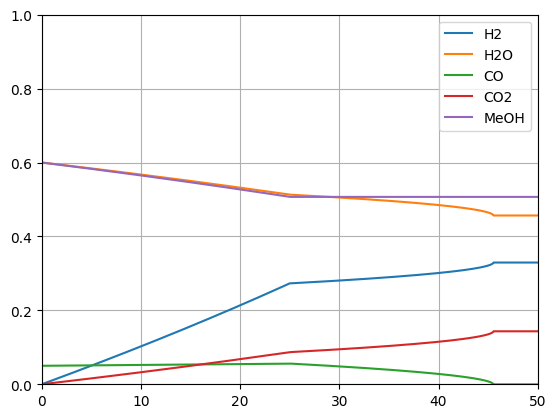

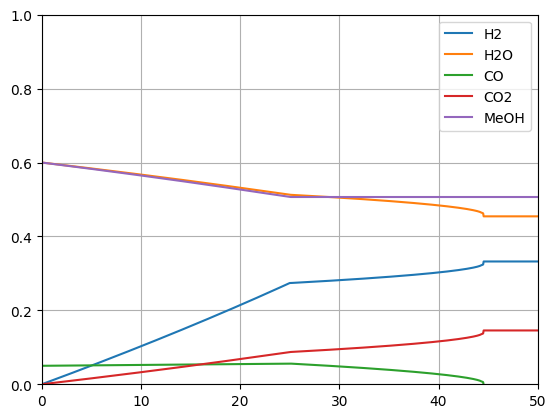

In [165]:
# @title full plot
plt.figure(1)
plt.plot(Vspan, ConcEul[:,0], label='H2')
plt.plot(Vspan, ConcEul[:,1], label='H2O')
plt.plot(Vspan, ConcEul[:,2], label='CO')
plt.plot(Vspan, ConcEul[:,3], label='CO2')
plt.plot(Vspan, ConcEul[:,4], label='MeOH')

plt.axis((0, 50, 0, 1))
plt.legend(loc='best')
plt.grid()

plt.figure(2)
plt.plot(Vspan, ConcRK[:,0], label='H2')
plt.plot(Vspan, ConcRK[:,1], label='H2O')
plt.plot(Vspan, ConcRK[:,2], label='CO')
plt.plot(Vspan, ConcRK[:,3], label='CO2')
plt.plot(Vspan, ConcRK[:,4], label='MeOH')

plt.axis((0, 50, 0, 1))
plt.legend(loc='best')
plt.grid()


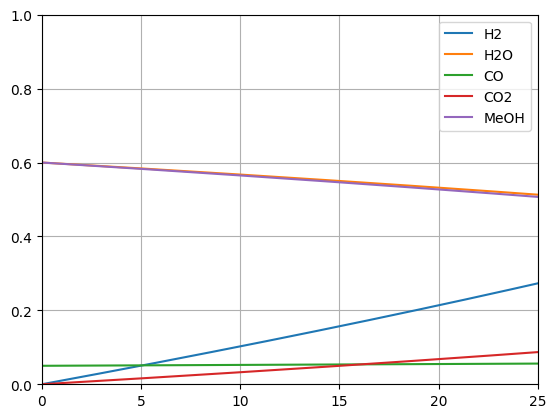

In [166]:
# @title MSR + MD plot

plt.figure(3)
plt.plot(Vspansplit, ConcEul1[:,0], label='H2')
plt.plot(Vspansplit, ConcEul1[:,1], label='H2O')
plt.plot(Vspansplit, ConcEul1[:,2], label='CO')
plt.plot(Vspansplit, ConcEul1[:,3], label='CO2')
plt.plot(Vspansplit, ConcEul1[:,4], label='MeOH')

plt.axis((0, 25, 0, 1))
plt.legend(loc='best')
plt.grid()


In [170]:
# @title code testing block || IGNORE

'''
H = np.array (
   [[1, 1, 1],
   [2, 2, 2],
   [7, 3, 3],
   [4, 4, 4]])

Hres = np.zeros(len(H))

for i in range(len(H)):
 Hres[i] = H[i,0]*H[i,1]*H[i,2]


print(Hres)

A = 3*10**-3
B = 3*np.power(10,-3, dtype=float)

print(A)
print(B)

C=np.array(
   [[1, 2, 1, 1, 2],
   [1, 3, 1, 1, 3]]
)

rWGS = np.zeros(2)
rWGS2 = np.zeros(2)


for i in range(2):
 rWGS[i] = WGS[i,0]*np.exp((-WGS[i,1]/R)*(1/T-1/T0))*C[i, 3]**WGS[i,2]*C[i, 2]**WGS[i,3]
 rWGS2[i] = WGS[i,0]*np.exp((-WGS[i,1]/R)*(1/T-1/T0))*np.power(C[i, 3], WGS[i,2], dtype=float)*np.power(C[i, 2], WGS[i,3], dtype=float)

print(rWGS)
print(rWGS2)

m = np.array([[5, 10]])
c = np.array([[1, 2], [3, 4]])

huh = np.multiply(rWGS[0], ny[:, 0])
huh2 = rWGS[0]*ny[:,0]
print(huh)
print(huh2)

ReakFun test
ReakFun(t, C, T, MSRind, MDind, WGSind)
pls = ReakFun(0, IC, 300, 0, 0, 0)
print(pls)

np.transpose test
ktemp = np.zeros([10, 3])
ktemp[0,:] = 1
k = np.transpose(ktemp[1, :])
print(ktemp)
print(k)
'''
print()